<a href="https://colab.research.google.com/github/ksydata/HanaDT_SubProject/blob/main/TimeSeriesDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarning("always")
# wainfogs.filterwarnings("ignore")

# System related and Data input controls
import os

import re
from typing import *
import missingno as msno

# Web Scraping & Crawling
import requests
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

import urllib.request
import json
from pandas.io.json import json_normalize

# Data manipulation and visualization
import pandas as pd
import datetime
# pd.options.display.float_format = "{:, 0.2f}".format
# pd.options.display.max_rows = 100
# pd.options.display.max_columns = 20
# pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Modeling algorithms
# (1) General
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

# (2) Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for Regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sys import executable                                                        
# print(executable)
# C:\ProgramData\anaconda3\python.exe

import sys
# print(sys.path)
# C:\programdata\anaconda3\lib\site-packages

# [Error]
# python3 -m ipykernel install --user
# /C:/ProgramData/anaconda3/python -m pip install request
# !{sys.executable} -m pip install request
# !conda install --yes --prefix {sys.prefix} request

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
from tqdm import tqdm
import time
time.sleep(2)

In [5]:
# GetRepoTradInfoService
    # 기준일자, RP거래일자를 조회하여 
    # 건별거래, 매입증권별잔고금액, 통화별잔고금액을 제공하는 금융위원회_REPO거래정보
    
class GetRepoTradingInfoService():
    
    def __init__(self, 
                 request_url: str, 
                 parameters = None,
                 response = None, 
                 repo_object = None):
        
        self.request_url = request_url
        self.response = response
        self.repo_object = repo_object
            # encoding key = "XaWt3XckF7z5yo3JX%2BMBifN3A6o6cBoIlo3hB0sZznUGKpCHCcOZz4ifqAYfWcRPYLWjJG2dbqEFUXfmr29Xzg%3D%3D"
            # decoding key = "XaWt3XckF7z5yo3JX+MBifN3A6o6cBoIlo3hB0sZznUGKpCHCcOZz4ifqAYfWcRPYLWjJG2dbqEFUXfmr29Xzg=="

            
# requestHTMLWebpage()
    def requestHTMLWebpage(self, baseDate: str):
        
    # 공공데이터포털에서 xml 데이터 요청
        parameters ={
            "serviceKey" : "XaWt3XckF7z5yo3JX+MBifN3A6o6cBoIlo3hB0sZznUGKpCHCcOZz4ifqAYfWcRPYLWjJG2dbqEFUXfmr29Xzg==", 
            "numOfRows" : "1", 
            "pageNo" : "1", 
            "resultType" : "xml", 
            "basDt" : baseDate}
            # 분석에 활용하기 위한 수집 방법
                # 파라미터 딕셔너리의 key값을 변수로 변환하여 class의 method return값을 for문을 통해 날짜별로 생성하여
                # 전역공간에 데이터프레임으로 일별 환매조건부매매채권 데이터 1차원 배열을 병합

        response = requests.get(
            self.request_url, 
            params = parameters)
            # timeout = 0.1)
        self.response = response
            # request_url
                # [통화별잔고금액] http://apis.data.go.kr/1160100/service/GetRepoItemInfoService/getInteRateInfo
                # [건별거래조회] http://apis.data.go.kr/1160100/service/GetRepoTradInfoService/getCaseForTrad
                # [매입증권별 잔고금액 조회] http://apis.data.go.kr/1160100/service/GetRepoTradInfoService/getBuyiSecuBala
        # print(response.content)
        # print(response.text)
                # 요청한 웹페이지 문서가 로드되었는지 확인용
            
    # 데이터 수집
        soup_object = BeautifulSoup(response.content, 
                            "lxml-xml")
        repo_object = soup_object.find_all("item")
        self.repo_object = repo_object
                
        
# Trial & Error : 지속가능성이 없는 방법으로 사용하지 않음
# getInterestRateData()
# REPO 종목정보
    def getInterestRateData(self):
    
    # 데이터 정리
        RepoInterestData: List = []
    
        for i in range(len(self.repo_object)):
            
            baseDate = self.repo_object[i].basDt.string.strip()
            repoID = self.repo_object[i].rpSqno.string.strip()
            
            repoBuySecurities = self.repo_object[i].rpBuyScrtKcd.string.strip()
            repoBuyApplyCurrent = self.repo_object[i].rpBuyAplCurCd.string.strip()
            repoBuyApplyCurrentNM = self.repo_object[i].rpBuyAplCurCdNm.string.strip()
            
            repoDepositTermCode = self.repo_object[i].rdptTermCcd.string.strip()
            repoDepositTermCodeNM = self.repo_object[i].rdptTermCcdNm.string.strip()
            
            repoRemainingExprDcd = self.repo_object[i].rpRmngExprDcd.string.strip()
            repoRemainingExprDcdNm = self.repo_object[i].rpRmngExprDcdNm.string.strip()
            
            purchaseBzTypeCode = self.repo_object[i].purcBzcTcd.string.strip()
            purchaseBzTypeCodeNM = self.repo_object[i].purcBzcTcdNm.string.strip()
            sellerBzTypeCode = self.repo_object[i].slrBzcTcd.string.strip()
            sellerBzTypeCodeNM = self.repo_object[i].slrBzcTcdNm.string.strip()
            
            repoInterest = self.repo_object[i].rpInrt.string.strip()
    
            RepoInterestData = [
                baseDate, repoID, 
                repoBuySecurities, repoBuyApplyCurrent, repoBuyApplyCurrentNM, 
                repoDepositTermCode, repoDepositTermCodeNM, repoRemainingExprDcd, repoRemainingExprDcdNm,
                purchaseBzTypeCode, purchaseBzTypeCodeNM, sellerBzTypeCode, sellerBzTypeCodeNM, repoInterest]
    
            RepoInterestData.append(RepoInterestData)
        
        return RepoInterestData
    

# getTradingData()
# Repo 거래정보
    def getTradingData(self):  
        
        listofItems: List = []
        listofItems = [ [data.text for data in item] for item in self.repo_object ]
        listofItems = list(*listofItems)
          # 이중 리스트에 내포된 <items> tag 내 데이터를 에스터리스크 *를 활용하여 단일 리스트 내 포함되도록 함
        listofItem = list(filter(lambda data: data != "\n", listofItems))
          # <items>
        
        return listofItem

##### 1. 건별 종목정보(금리 등)

getRepoInterest : 환매조건부채권 금리
    
    # baseDate | 기준일자
    # repoID | RP일련번호
    # repoBuySecurities | 기업어음의 매입증권 종류를 관리하는 코드 (통안채, 국채, 은행채 등)
    # repoBuyApplyCurrent | 기업어음의 매입증권 종류를 관리하는 코드 (통안채, 국채, 은행채 등)
    # repoBuyApplyCurrentNM | 환매조건부채권(RP)을 매입 할때 적용되는 통화를 관리하는 코드의 명칭
    # repoDepositTermCode | 상환 기간에 따라 기간을 분류한 코드
    # repoDepositTermCodeNM | 상환 기간에 따라 기간을 분류한 코드의 명칭
    # repoRemainingExprDcd | 기업어음(RP)의 잔존 만기 기간을 구분하는 코드
    # repoRemainingExprDcdNM | 기업어음(RP)의 잔존 만기 기간을 구분하는 코드의 명칭
    # purchaseBzTypeCode | 매수자 업종별 유형을 관리하는 코드
    # purchaseBzTypeCodeNM| 매수자 업종별 유형을 관리하는 코드의 명칭
    # sellerBzTypeCode | 매도자 업종별 유형을 관리하는 코드
    # sellerBzTypeCodeNM | 매도자 업종별 유형을 관리하는 코드의 명칭
    # repoInterest | 환매조건부채권거래 매수자 제공 매입금액에 대한 이율

In [ ]:
getRepoInterest = GetRepoTradingInfoService(
    request_url = "http://apis.data.go.kr/1160100/service/GetRepoItemInfoService/getInteRateInfo"
)
getRepoInterest.requestHTMLWebpage(
    baseDate = "20200304")

In [ ]:
getRepoInterest.getInterestRateData()

['20200304',
 '202003040001',
 '1150',
 'KRW',
 '대한민국 원',
 '1',
 '1영업일',
 '11',
 '1년이하',
 '0202',
 '은행(신탁)',
 '0101',
 '증권사',
 '1.43',
 [...]]

##### 2. 건별 거래조회, 매입증권별 잔고금액 조회, 통화별 잔고금액 조회

(1) getCaseForTrad : RP이율, RP증거금비율, 매입증권매입금액, 매입증권평가금액등을 조회하는 건별거래조회

(2) getBuyiSecuBala : RP국채담보금액, RP금융채담보금액, 지방채담보금액, 담보총합계금액등을 조회

(3) getCurrBala : RP거래일자를 통하여 거래유형코드, RP매입적용통화코드, RP매입적용통화코드명, RP통화잔액등을 조회

In [ ]:
getCaseForTrading = GetRepoTradingInfoService(
    request_url = "http://apis.data.go.kr/1160100/service/GetRepoTradInfoService/getCaseForTrad"
)
getBuyiSecuritiesBalance = GetRepoTradingInfoService(
    request_url = "http://apis.data.go.kr/1160100/service/GetRepoTradInfoService/getBuyiSecuBala"
)
getCurrentBalanceSheet =  GetRepoTradingInfoService(
    request_url = "http://apis.data.go.kr/1160100/service/GetRepoTradInfoService/getCurrBala"
)

In [ ]:
# [Instance] getCaseForTrading
# self.repo_object
getCaseForTrading.requestHTMLWebpage(baseDate = "20200303")
# self.response.text
getCaseForTrading.getTradingData()

# [Instance] getBuyiSecuritiesBalance 
# self.repo_object
getBuyiSecuritiesBalance.requestHTMLWebpage(baseDate = "20200303")
# self.response.text
getBuyiSecuritiesBalance.getTradingData()

# [Instance] getCurrentBalanceSheet
# self.repo_object
getCurrentBalanceSheet.requestHTMLWebpage(baseDate = "20200303")
# self.response.text
getCurrentBalanceSheet.getTradingData()

[<item>
<basDt>20200303</basDt>
<buyScrtBuyAmt>5500000000</buyScrtBuyAmt>
<buyScrtCnt>5800000000</buyScrtCnt>
<buyScrtEvlAmt>5843505800</buyScrtEvlAmt>
<buynShtrFinBzcDcd>0204</buynShtrFinBzcDcd>
<buynShtrFinBzcDcdNm>집합투자</buynShtrFinBzcDcdNm>
<isinCd>KR310502G957</isinCd>
<isinCdNm>중금채(신) 1905이2A-15</isinCdNm>
<rdptTermCcd>2</rdptTermCcd>
<rdptTermCcdNm>2영업일이상 7일미만</rdptTermCcdNm>
<rpBuyAmt>5500000000</rpBuyAmt>
<rpBuyAplCurCd>KRW</rpBuyAplCurCd>
<rpBuyAplCurCdNm>대한민국 원</rpBuyAplCurCdNm>
<rpInrt>1.35</rpInrt>
<rpMrgamRto>105</rpMrgamRto>
<rpOpngDt>20200303</rpOpngDt>
<rpRmngExprDcd>12</rpRmngExprDcd>
<rpRmngExprDcdNm>3년이하</rpRmngExprDcdNm>
<rpSqno>202003030001</rpSqno>
<scrsItmsKcd>1150</scrsItmsKcd>
<scrsItmsKcdNm>은행채</scrsItmsKcdNm>
<slngShtrFinBzcDcd>0204</slngShtrFinBzcDcd>
<slngShtrFinBzcDcdNm>집합투자</slngShtrFinBzcDcdNm>
</item>]
[<item>
<basDt>20200303</basDt>
<etcBondMogAmt>0</etcBondMogAmt>
<etfMogAmt>694159073000</etfMogAmt>
<lcbndMogAmt>348309276509</lcbndMogAmt>
<mogTsumAmt>

['CNY', '위안화', '89360181', '20140829', '02', '']

In [ ]:
CaseForTradingRepo = pd.DataFrame()
col_num = 0

dates = pd.date_range(
    "2020-01-01", 
    "2023-01-01",
    freq = "D")
    # [freq] D, M, Y
    # start_date = pd.to_datetime('2020-01-01')
    # end_date = pd.to_datetime('2023-01-01')
date_list = dates.strftime("%Y%m%d").tolist()

In [ ]:
# self.repo_object
getCaseForTrading.requestHTMLWebpage(baseDate = "20200103")

# self.response.text
getCaseForTrading.getTradingData()

['20200103',
 '9610805222',
 '10000000000',
 '10110250000',
 '0202',
 '은행(신탁)',
 'KR60000148C7',
 '신한은행 22-12-이-3-B',
 '1',
 '1영업일',
 '100000000000',
 'KRW',
 '대한민국 원',
 '1.43',
 '105',
 '20200103',
 '12',
 '3년이하',
 '202001030001',
 '1150',
 '은행채',
 '0101',
 '증권사']

In [ ]:
len(date_list), date_list[0], date_list[-1]

(1097, '20200101', '20230101')

#### 3. 

Repo data : JH Solution

(1) 영업일 및 비영업일 구분하는 try except문

(2) for문에서 dictionary 타입 활용하여 각 시계열 key에 해당하는  환매조건부채권 value값 병합

In [ ]:
for date in date_list[:10]:
    try:
        getCaseForTrading.requestHTMLWebpage(baseDate = date)
        # self.response.text
        print(# "\n column 갯수:", 
              len( getCaseForTrading.getTradingData() ))
        print(bool( getCaseForTrading.getTradingData() ))
        CaseForTradingRepo.loc[col_num, :] = getCaseForTrading.getTradingData()
        
    except:
        print(":비영업일")
        pass

0
False
23
True
:비영업일
23
True
:비영업일
0
False
0
False
23
True
:비영업일
23
True
:비영업일
23
True
:비영업일
23
True
:비영업일
23
True
:비영업일


In [ ]:
tmp_dict = {}

for i, date in enumerate(tqdm(date_list)):
    
    getCaseForTrading.requestHTMLWebpage(baseDate = date)
    
    if bool(getCaseForTrading.getTradingData()) == True:
        # print(len(getCaseForTrading.getTradingData()))
        tmp_dict[i] = getCaseForTrading.getTradingData()
    else:
        # print(len(getCaseForTrading.getTradingData()))
        pass

100%|██████████| 1097/1097 [08:28<00:00,  2.16it/s]


In [ ]:
CaseForTradingRepo = pd.DataFrame( tmp_dict ).transpose()
CaseForTradingRepo.reset_index(drop = True, inplace = True)
CaseForTradingRepo.columns = [
    "기준일자", "매입증권수", "매입증권매입금액", "매입증권평가금액", "매수단기금융업종구분코드", "매수단기금융업종명", "유가증권국제인증고유번호",
    "유가증권국제인증고유번호코드명", "상환기간분류코드", "상환기간분류코드명", 
    "RP매입금액", "RP매입적용통화코드", "RP매입적용통화명", "RP이율", "RP증거금비율", 
    "RP개시일자", "RP잔존만기구분코드", "RP잔존만기", "RP일련번호", "유가증권종목종류코드", # 우선주/보통주
    "유가증권종목명", "매도단기금융업종구분코드", "매도단기금융업종명" 
]
CaseForTradingRepo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준일자             680 non-null    object
 1   매입증권수            680 non-null    object
 2   매입증권매입금액         680 non-null    object
 3   매입증권평가금액         680 non-null    object
 4   매수단기금융업종구분코드     680 non-null    object
 5   매수단기금융업종명        680 non-null    object
 6   유가증권국제인증고유번호     680 non-null    object
 7   유가증권국제인증고유번호코드명  680 non-null    object
 8   상환기간분류코드         680 non-null    object
 9   상환기간분류코드명        680 non-null    object
 10  RP매입금액           680 non-null    object
 11  RP매입적용통화코드       680 non-null    object
 12  RP매입적용통화명        680 non-null    object
 13  RP이율             680 non-null    object
 14  RP증거금비율          680 non-null    object
 15  RP개시일자           680 non-null    object
 16  RP잔존만기구분코드       680 non-null    object
 17  RP잔존만기           680 non-null    ob

In [109]:
CaseForTradingRepo.iloc[0:10, ]
  # 2020-01-10 데이터 반복되어 하단의 TimeSeriesFeatureEngineering에서 reindex(asfreq = "Day") 시 오류 발생

,기준일자,매입증권수,매입증권매입금액,매입증권평가금액,매수단기금융업종구분코드,매수단기금융업종명,유가증권국제인증고유번호,유가증권국제인증고유번호코드명,상환기간분류코드,상환기간분류코드명,...,RP이율,RP증거금비율,RP개시일자,RP잔존만기구분코드,RP잔존만기,RP일련번호,유가증권종목종류코드,유가증권종목명,매도단기금융업종구분코드,매도단기금융업종명
0,20200110,1000000,1020000000,1283883180,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200110,14.0,10년이하,202001100001,1110,국채,101,증권사
1,20200103,9610805222,10000000000,10110250000,202,은행(신탁),KR60000148C7,신한은행 22-12-이-3-B,1,1영업일,...,1.43,105,20200103,12.0,3년이하,202001030001,1150,은행채,101,증권사
2,20200106,19059592543,20000000000,20031100000,201,증권사(신탁),KR310508G996,중소기업은행(신) 1909이1.5A-24,1,1영업일,...,1.40,105,20200106,12.0,3년이하,202001060001,1150,은행채,701,여신 금융업
3,20200107,1000000,1020000000,1295321460,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200107,14.0,10년이하,202001070001,1110,국채,101,증권사
4,20200108,1000000,1020000000,1289487060,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200108,14.0,10년이하,202001080001,1110,국채,101,증권사
5,20200109,1000000000,1050000000,1055736150,204,집합투자,KR6000881732,한화 216,1,1영업일,...,1.45,105,20200109,11.0,1년이하,202001090001,1170,회사채,204,집합투자
6,20200110,1000000,1020000000,1283883180,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200110,14.0,10년이하,202001100001,1110,국채,101,증권사
7,20200113,800000000,843000000,840052872,204,집합투자,KR6003411990,쌍용양회공업 313-2,1,1영업일,...,1.50,105,20200113,13.0,5년이하,202001130001,1170,회사채,101,증권사
8,20200114,9542417377,10000000000,10056870000,101,증권사,KR310201G915,산금채 19신이0200-0102-1,1,1영업일,...,1.35,105,20200114,11.0,1년이하,202001140001,1150,은행채,701,여신 금융업
9,20200115,1000000,1020000000,1284409500,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200115,14.0,10년이하,202001150001,1110,국채,101,증권사


In [111]:
CaseForTradingRepo.drop(0, axis = 0, inplace = True)

In [113]:
CaseForTradingRepo.to_csv(
    "/content/drive/MyDrive/archive/CaseForTradingRepoData.csv", 
    index = False,
    encoding = "utf-8"
)
# CaseForTradingRepo.to_excel("./RepoCaseForTradingData.xlsx")

---

In [ ]:
BuyRepoSecuritiesBalance = pd.DataFrame()

for date in date_list[:10]:
    try:
        getBuyiSecuritiesBalance.requestHTMLWebpage(baseDate = date)
        # self.response.text
        print(# "\n column 갯수:", 
              len( getBuyiSecuritiesBalance.getTradingData() ))
        print(bool( getBuyiSecuritiesBalance.getTradingData() ))
        BuyRepoSecuritiesBalance.loc[col_num, :] = getBuyiSecuritiesBalance.getTradingData()
        
    except:
        print(":비영업일")
        pass

0
False
12
True
:비영업일
12
True
:비영업일
0
False
0
False
12
True
:비영업일
12
True
:비영업일
12
True
:비영업일
12
True
:비영업일
12
True
:비영업일


In [ ]:
tmp_dict = {}

for i, date in enumerate(tqdm(date_list)):
    
    getBuyiSecuritiesBalance.requestHTMLWebpage(baseDate = date)
    
    if bool(getBuyiSecuritiesBalance.getTradingData()) == True:
        # print(len(getBuyiSecuritiesBalance.getTradingData()))
        tmp_dict[i] = getBuyiSecuritiesBalance.getTradingData()
    else:
        # print(len(getBuyiSecuritiesBalance.getTradingData()))
        pass

100%|██████████| 1097/1097 [10:01<00:00,  1.82it/s]


In [ ]:
BuyRepoSecuritiesBalance = pd.DataFrame( tmp_dict ).transpose()
BuyRepoSecuritiesBalance.reset_index(drop = True, inplace = True)
BuyRepoSecuritiesBalance.columns = [
    "기준일자", "기타채권담보금액", "ETF담보금액", "지방채담보금액", "RP회사채담보금액",
    "담보총합계금액", "RP회사채담보금액", "RP금융채담보금액", "RP국채담보금액", "RP통안채담보금액", 
    "RP유형코드", "RP유형"
]
BuyRepoSecuritiesBalance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   기준일자       745 non-null    int64 
 1   기타채권담보금액   745 non-null    int64 
 2   ETF담보금액    745 non-null    int64 
 3   지방채담보금액    745 non-null    int64 
 4   RP회사채담보금액  745 non-null    int64 
 5   담보총합계금액    745 non-null    int64 
 6   RP회사채담보금액  745 non-null    int64 
 7   RP금융채담보금액  745 non-null    int64 
 8   RP국채담보금액   745 non-null    int64 
 9   RP통안채담보금액  745 non-null    int64 
 10  RP유형코드     745 non-null    int64 
 11  RP유형       745 non-null    object
dtypes: int64(11), object(1)
memory usage: 70.0+ KB


In [ ]:
BuyRepoSecuritiesBalance

,기준일자,기타채권담보금액,ETF담보금액,지방채담보금액,RP회사채담보금액,담보총합계금액,RP회사채담보금액,RP금융채담보금액,RP국채담보금액,RP통안채담보금액,RP유형코드,RP유형
0,20200102,0,773681367000,308589262934,121143155894665,2274373147743,37080147815711,66065555761910,8535866543280,6104941996087,1,기관REPO
1,20200103,0,764050163500,307985906980,118894057064686,2238265733452,37071210314952,64322365536497,8056719789268,6133459620037,1,기관REPO
2,20200106,4957089041,762145704000,276643581308,115669692144394,2370464917986,36263492099076,62317491308585,7416760983662,6257736460736,1,기관REPO
3,20200107,4957870548,755263151500,265736338554,114022695703078,2341148082136,35752705222749,61586627601288,7261508422991,6054749013312,1,기관REPO
4,20200108,4958764384,762029387000,287284482492,115535262416722,2341696467864,36144294887770,62244703713304,7624005236852,6126289477056,1,기관REPO
...,...,...,...,...,...,...,...,...,...,...,...,...
740,20221226,0,1441012350000,387249331313,193136576501302,6655344509213,36547594259324,123538218445915,8163058423987,16404099181550,1,기관REPO
741,20221227,0,1540906785000,375921287777,194655730928261,6573577711936,36196167270187,125401534853721,8163633710705,16403989308935,1,기관REPO
742,20221228,0,1548146855000,378855644625,194851439259849,6510444129195,36266272028456,125553687822155,8573516961752,16020515818666,1,기관REPO
743,20221229,0,1535898355000,370599952574,194704793134209,6412972341205,36167007246044,125706195490261,8042452060156,16469667688969,1,기관REPO


In [ ]:
"""
BuyRepoSecuritiesBalance.to_csv(
    "/content/drive/MyDrive/archive/BuyRepoSecuritiesBalance.csv", 
    index = False,
    encoding = "utf-8")
"""

---

#### 4. 
Feature Engineering

* **시간현실반영**
* 변수 간 스케일 조정
* 다중공선성 제거

* 임의의 $t$에 대하여 $E(X_{t}) = μ $

* 임의의 $t$에 대하여 $Var(X_t) < ∞ $
: 분산이 안정적이지 못하기 때문에 정상적이지 않을 수도 있다.

* 임의의 t, h에 대하여 $Cov(X_{t+h}, X_t) = 𝛤(h) $
: 두 시점의 자기공분산(t+h시점과 t시점 간 공분산)은 시차(time lag)에만 의존한다, 약정상성을 띄는 시계열 데이터는 t시점에 관측하더라도 기댓값과 분산이 변하지 않는다.

* ADF Test 모듈 내부 알고리즘

  ```
if regression != "n":
        resols = OLS(
            xdshort, add_trend(xdall[:, : usedlag + 1], regression)
        ).fit()
    else:
        resols = OLS(xdshort, xdall[:, : usedlag + 1]).fit()
```

In [39]:
class TimeSeriesFeatureEngineering():

  def __init__(self, 
               trading_repo_path: str, bs_repo_path: str
               # , X_train = None, X_test = None, Y_train = None, Y_test = None
               ):
    
    self.trading_repo_path = trading_repo_path
    self.bs_repo_path = bs_repo_path
    # self.X_train = X_train 
    # self.X_test = X_test 
    # self.Y_train = Y_train 
    # self.Y_test = Y_test


# ImportDataset()
  # GetRepoTradingInfoService 클래스를 통해 불러온 2020-01-01 ~ 2023-01-01까지 
  # 환매조건부채권(RP) 건별거래, 매입증권별잔고금액 데이터 로드하여 dataframe으로 병합
  # 클래스 내부에 캡슐화하지 않고 main()에서 return값으로 생성하여 전역공간에 저장 
  def ImportDataset(self):

    CaseForTradingRepo = pd.read_csv(
        self.trading_repo_path, index_col = False, encoding = "utf-8")
    BuyRepoSecuritiesBalance = pd.read_csv(
        self.bs_repo_path, index_col = False, encoding = "utf-8")
    # dataframe = CaseForTradingRepo.merge(right = BuyRepoSecuritiesBalance, how = "left", on = "기준일자")
    dataframe = CaseForTradingRepo.copy()
    return dataframe


# NonFeatureEngineering()
# 데이터 전처리하지 않은 데이터프레임 반환(F.E한 경우와 비교 목적)
  def NonFeatureEngineering(self, date_column, dataframe):

  # 기준일자 컬럼을 date_column변수로 입력받아 날짜형 타입 변환
    dataframe[date_column] = dataframe[date_column].astype("str")
    dataframe[date_column] = dataframe[date_column].apply(
        lambda x: datetime.datetime.strptime(x, "%Y%m%d"))
    # [AttributeError] module 'datetime' has no attribute 'strftime'
      # dataframe[date_column] = dataframe[date_column].apply(lambda x: x.strftime("%Y-%m-%d"))
      # dataframe[date_column] = dataframe[date_column].apply(lambda x: x.datetime.strftime("%Y-%m-%d"))
    # [ValueError] time data '20200110' does not match format '%Y-%m-%d'
      # dataframe[date_column] = dataframe[date_column].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

    if date_column in dataframe.columns:
      # dataframe["datetime"] = pd.to_datetime(dataframe[date_column])
      dataframe["DateTime"] = pd.to_datetime(dataframe[date_column])
  # 인덱스 타입이 64비트 정수형이면, DateTime컬럼으로 변경 
    if dataframe.index.dtype == "int64":
      dataframe.set_index("DateTime", inplace = True)
    dataframe.drop(["기준일자", "RP개시일자", "RP일련번호"], axis = 1, inplace = True)

  # 범주형 변수 더미화 및 범주형 변수 코드명(식별자) 제거
    dataframe.drop(
        ["매수단기금융업종구분코드", "RP매입적용통화코드", 
         "유가증권종목종류코드", "유가증권국제인증고유번호", "유가증권국제인증고유번호코드명",
         "상환기간분류코드", "RP잔존만기구분코드", "매도단기금융업종구분코드"], axis = 1, inplace = True)
    factor_column_list: List = dataframe.select_dtypes(include = "object").columns.tolist()
    dataframe[factor_column_list] = dataframe[factor_column_list].astype("category")
    pd.get_dummies(dataframe, columns = factor_column_list)
    dataframe.drop(factor_column_list, axis = 1, inplace = True)

    dataframe_NonFE = dataframe.copy()
    dataframe_NonFE.drop("datetime", axis = 1, inplace = True)
    return dataframe_NonFE


# FeatureEngineering()
  def FeatureEngineering(self, 
                         date_column: str, dataframe: str, 
                         Y: str, decompose_method: str,
                         grouping_feature: str):
    
  # 기준일자 컬럼을 date_column변수로 입력받아 날짜형 타입 변환
    dataframe[date_column] = dataframe[date_column].astype("str")
    dataframe[date_column] = dataframe[date_column].apply(
        lambda x: datetime.datetime.strptime(x, "%Y%m%d"))
    # pd.set_option("display.max_rows", None)
    # print(dataframe.groupby([date_column]).size())

    if date_column in dataframe.columns:
      # dataframe["datetime"] = pd.to_datetime(dataframe[date_column])
      dataframe["DateTime"] = pd.to_datetime(dataframe[date_column])
  # 인덱스 타입이 64비트 정수형이면, DateTime컬럼으로 변경 
    if dataframe.index.dtype == "int64":
      dataframe.set_index("DateTime", inplace = True)
  # 인덱스 시계열 "Day" 1일 단위로 설정
    dataframe.drop(["기준일자", "RP개시일자", "RP일련번호"], axis = 1, inplace = True)
    # print(dataframe, dataframe.info())
    dataframe = dataframe.asfreq("D", method = "ffill")
      # [ValueError] cannot reindex a non-unique index with a method or limit

  # 범주형 변수 더미화 및 범주형 변수 코드명(식별자) 제거 -> 오류의 연속
    dataframe.drop(
        ["매수단기금융업종구분코드", "RP매입적용통화코드", 
         "유가증권종목종류코드", "유가증권국제인증고유번호", "유가증권국제인증고유번호코드명",
         "상환기간분류코드", "RP잔존만기구분코드", "매도단기금융업종구분코드"], axis = 1, inplace = True)
    factor_column_list: List = dataframe.select_dtypes(include = "object").columns.tolist()
    dataframe[factor_column_list] = dataframe[factor_column_list].astype("category")
    # [print(dataframe[column_name].unique()) for column_name in factor_column_list]
    
    pd.get_dummies(data = dataframe[factor_column_list])
      # pandas.get_dummies는 train 데이터의 특성을 학습하지 않기 때문에 train 데이터에만 있고 
      # test 데이터에는 없는 카테고리를 test 데이터에서 원핫인코딩 된 칼럼으로 바꿔주지 않는다.
      # 결론은 쓰지 말아야 한다?

    # dummyTransformer = OneHotEncoder()
    # dummyTransformer.fit(dataframe[factor_column_list])

    # dataframe_factor_to_dummy = pd.DataFrame()
    # for column_name in factor_column_list:
      # dummyTransformer.fit(np.asarray(dataframe[[column_name]]).reshape(-1, 1))
        # ValueError: Expected 2D array, got 1D array instead: array=['은행(신탁)' '은행(신탁)' '은행(신탁)' ... '은행(신탁)' '국내은행' '여신 금융업']
        # Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
      # dataframe_factor_to_dummy = dummyTransformer.fit_transform(dataframe[column_name])
      # dataframe_factor_to_dummy = pd.DataFrame(
          # dataframe_factor_to_dummy, columns = [column_name + col for col in dummyTransformer.categories_[0]])
    # print(dataframe_factor_to_dummy)
    # pd.concat([dataframe, dataframe_factor_to_dummy], axis = 1)

    # [ValueError] Shape of passed values is (1093, 1), indices imply (1093, 12)
      # globals()["dataframe_factor_to_dummy_{}".format(column_name)] = dummyTransformer.transform(dataframe[[column_name]])
          # '<class 'scipy.sparse._csr.csr_matrix'>' 희소행렬로 반환
      # globals()["dataframe_factor_to_dummy_{}".format(column_name)]= pd.DataFrame(
          # globals()["dataframe_factor_to_dummy_{}".format(column_name)], columns = [column_name + col for col in dummyTransformer.categories_[0]])
          # TypeError: Field elements must be 2- or 3-tuples, got ''매수단기금융업종명''

    dataframe.drop(factor_column_list, axis = 1, inplace = True)
  
  # 시계열 분해 : 추세 + 계절성 + 잔차 or 추세 * 계절성 * 잔차
    decomposition = sm.tsa.seasonal_decompose(
        dataframe[Y],
        model = decompose_method)
      # sm.tsa.seasonal_decompose(model = "")
      # [input] additive, multicative
    Y_trend = pd.DataFrame(
        decomposition.trend)
    Y_trend.fillna(method = "ffill", inplace = True)
    Y_trend.fillna(method = "bfill", inplace = True)
    Y_trend.columns = ["y_trend"]
      # f{} string formating으로 변수명 입력받을 수 있으나 생략

    Y_seasonal = pd.DataFrame(
        decomposition.seasonal)
    Y_seasonal.fillna(method = "ffill", inplace = True)
    Y_seasonal.fillna(method = "bfill", inplace = True)
    Y_seasonal.columns = ["y_seasonal"]

    pd.concat([dataframe, Y_trend, Y_seasonal], axis = 1).isnull().sum()
    if "y_trend" not in dataframe.columns:
      if "y_seasonal" not in dataframe.columns:
        dataframe = pd.concat([dataframe, Y_trend, Y_seasonal], axis = 1)

  # 특정 시점을 기준으로 전후 12일씩 총 24일간의 이동평균된 pandas Series타입
    Y_day = dataframe[[Y]].rolling(24).mean()
    Y_day.fillna(method = "ffill", inplace = True)
    Y_day.fillna(method = "bfill", inplace = True)
    Y_day.columns = ["y_day"]

    Y_week = dataframe[[Y]].rolling(24 * 7).mean()
    Y_week.fillna(method = "ffill", inplace = True)
    Y_week.fillna(method = "bfill", inplace = True)
    Y_week.columns = ["y_week"]

    if "y_day" not in dataframe.columns:
      if "y_week" not in dataframe.columns:
        dataframe = pd.concat([dataframe, Y_day, Y_week], axis = 1)

  # 정상성(stationarity)을 나타내지 않는 시계열의 정상성을 나타내도록, 추세나 계절성을 완화하는 차분
  # 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는데 도움이 된다.
  # 다시 말해 비정상적 시계열은 누적 과정(integrated procss)이기 때문에 발생할 수 있다. 
  # (https://otexts.com/fppkr/decomposition.html)
    Y_differencing = dataframe[[Y]].diff()
    Y_differencing.fillna(method = "ffill", inplace = True)
    Y_differencing.fillna(method = "bfill", inplace = True)
      # [관측값의 차이, 차분] y_t = y_{t-1} + e_t
      # [2차 차분] ( y_t - y_{t-1} ) - ( y_{t-1} - y_{t-2} )
      # 2차 이상의 차분을 한 데이터로 적합한 모델의 설명력이 낮아질 수 있다. 
      # [계절성 차분] y_t - y_{t-m} (단, m은 계절 수)
    Y_differencing.columns = ["y_difference"]
    if "y_difference" not in dataframe.columns:
      dataframe = pd.concat([dataframe, Y_differencing], axis = 1)

  # MMMM-YY-DD HH (Week) 분할
    # dataframe[f"{grouping_feature}group"] = pd.cut(dataframe[grouping_feature], 10)
    
    dataframe["datetime"] = dataframe.index
    dataframe["Year"] = dataframe["datetime"].dt.year
    dataframe["Quarter"] = dataframe["datetime"].dt.quarter
    dataframe["Quarter_version2"] = dataframe["Quarter"] + (dataframe["Year"] - dataframe["Year"].min()) * 4
    dataframe["Day"] = dataframe["datetime"].dt.day
    dataframe["DayofWeek"] = dataframe["datetime"].dt.dayofweek

  # 데이터 관측시점들 간의 시차(lagging) 효과 반영
    dataframe["Y_lag1"] = dataframe[Y].shift(1)
    dataframe["Y_lag2"] = dataframe[Y].shift(2)
    dataframe["Y_lag1"].fillna(method = "bfill", inplace = True)
    dataframe["Y_lag2"].fillna(method = "bfill", inplace = True)

  # 분기 더미변수 생성
    if "Quarter" not in dataframe.columns:
      if "QuarterDummy" not in ["_".join(column.split("_")[:2]) 
                                for column in dataframe.columns]:
          dataframe = pd.concat(
              [dataframe, pd.get_dummies(dataframe["Quarter"], prefix = "QuarterDummy", drop_first=True)], 
              axis=1)
          del dataframe["Quarter"]

    dataframe_FE = dataframe.copy()
    dataframe_FE.drop("datetime", axis = 1, inplace = True)
    return dataframe_FE


# DataSplitofCrossSectional()
# 시계열을 고려하지 않고 분할한 훈련용, 검증용 종속변수(타겟), 독립변수(피쳐) 데이터 반환 
  def DataSplitofCrossSectional(self, 
                                cleandataframe: pd.DataFrame, Y_colname: str, X_colname: List, 
                                test_ratio: float, seed):
    
    X_train, X_test, Y_train, Y_test = train_test_split(
        cleandataframe[X_colname], cleandataframe[Y_colname], test_size = test_ratio, random_seed = seed)
    
    print(f"X_train : {X_train.shape}", f"Y_train : {Y_train.shape}")
    print(f"X_test : {X_test.shape}", f"Y_test : {Y_test.shape}")

    return X_train, X_test, Y_train, Y_test


# DataSplitofTimeSeries()
# 시계열을 고려하여 분할한 훈련용, 검증용 종속변수(타겟), 독립변수(피쳐) 데이터 반환 
  def DataSplitofTimeSeries(self, 
                            cleandataframe: pd.DataFrame, Y_colname: str, X_colname: List, 
                            criteria):
    
    dataframe_train = cleandataframe.loc[cleandataframe.index < criteria, :]
    dataframe_test = cleandataframe.loc[cleandataframe.index >= criteria, :]

    Y_train = dataframe_train[Y_colname]
    X_train = dataframe_train[X_colname]
    Y_test = dataframe_test[Y_colname]
    X_test = dataframe_test[X_colname]

    print(f"X_train : {X_train.shape}", f"Y_train : {Y_train.shape}")
    print(f"X_test : {X_test.shape}", f"Y_test : {Y_test.shape}")
    
  # 캡슐화시키지 않는 이유는 입력값을 F.E 유무에 따라 각각 투입하여 나온 결과를 비교하기 위함
    # self.X_train = X_train, 
    # self.X_test = X_test, 
    # self.Y_train = Y_train, 
    # self.Y_test = Y_test

    # return self
    return X_train, X_test, Y_train, Y_test


# Evaluationof1PairofSet()
  def Evaluationof1PairofSet(self, Y_refer, Y_pred, graph_on = False):

    loss_length = len(Y_refer.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_refer = Y_refer[loss_length:]

    if graph_on == True:
        pd.concat(
            [Y_refer, pd.DataFrame(Y_pred, index = Y_refer.index, columns = ["prediction"])], axis=1
        ).plot(kind = "line", figsize = (20, 6), 
               xlim = (Y_refer.index.min(), Y_refer.index.max()),
               linewidth = 3, fontsize = 20)
      
        plt.title("Time Series of Target", fontsize = 20)
        plt.xlabel("Index", fontsize = 15)
        plt.ylabel("Target Value", fontsize = 15)

  # 오차의 절댓값 평균
    MAE = abs(Y_refer.values.flatten() - Y_pred).mean()
  # 오차의 표준편차 평균
    MSE = ((Y_refer.values.flatten() - Y_pred)**2).mean()
  # 오차의 절댓값 백분율 평균
    MAPE = (abs(Y_refer.values.flatten() - Y_pred) / Y_refer.values.flatten() * 100).mean()
      
    Score = pd.DataFrame([MAE, MSE, MAPE], index=["MAE", "MSE", "MAPE"], columns = ["Score"]).T
    Residual = pd.DataFrame(Y_refer.values.flatten() - Y_pred, index = Y_refer.index, columns = ["Error"])
      
    return Score, Residual


  def EvaluationofTrainTestPairs(self, 
                                 Y_refer_train, Y_pred_train, Y_refer_test, Y_pred_test,
                                 graph_on):

  # 클래스 내부 멤버함수를 캡슐화하는 방법
    Score_train, Residual_train = self.Evaluationof1PairofSet(
        Y_refer_train, Y_pred_train, graph_on = graph_on)
    Score_test, Residual_test = self.Evaluationof1PairofSet(
        Y_refer_test, Y_pred_test, graph_on = graph_on)
    Score_train_test = pd.concat([Score_train, Score_test], axis=0)
    Score_train_test.index = ["Train", "Test"]
    
    # return self
    return Score_train_test, Residual_train, Residual_test


## 리뷰할 것(이게 최선일까) ##

# StationaryADFTest()
# 시계열의 정상성(Stationarity) 검정 : 관측된 시간과 시계열의 특징은 무관할까
# Ha : 시계열에 단위근이 존재하지 않는다. (시계열이 정상성을 만족한다)
# https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#adfuller
  def StationaryADFTest(self, 
                        Y_data, target_name):

  # target_name(y)가 지정되어 있지 않을 경우
    if len(target_name) == 0:

      stationary_adf = pd.Series(
          sm.tsa.stattools.adfuller(Y_data)[0:4],
          index = ["Test Statistics", "P-value", "Used Lag", "Number of Observations Used"])
        # y_t = a_1*y_t-1 + a_2*y_t-2 + ... + e_t
          # [단위근(unit root)] t시점의 확률변수는 t-1, t-2, ... 시점의 확률변수와 관계가 있으며 에러가 포함되는 것
        # m**p - m**(p-1)*a_1 - m**(p-2)*a_2 - ... - a_p = 0
          # [m = 1] 위 식의 근이 되는 m = 1이면 시계열 확률 과정은 단위근을 가진다고 말한다. 
          # 그렇지 않다면, 약 정상성을 띠는 t시점 시계열 데이터는 확률 과정의 성질(E(Xt), Var(Xt))이 변하지 않는다.

      for key, value in sm.tsa.stattools.adfuller(Y_data)[4].items():

        stationary_adf["Critical Values (%s)" %key] = value
          # 임계값(임계값 이상의 확률(극단적 방향으로 끝까지의 확률)이 a(유의수준)가 되는 자리값)
        stationary_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_data)[5]
          # Critical Value (5%)
        stationary_adf = pd.DataFrame(
            stationary_adf, columns = ["stationarity_adf"])

  # target_name(y)가 명시되어 있을 경우
    else:

      stationary_adf = pd.Series(
          sm.tsa.stattools.adfuller(Y_data[target_name])[0:4],
          index = ["Test Statistics", "P-value", "Used Lag", "Used Observations"])
      
      for key, value in sm.tsa.stattools.adfuller(Y_data[target_name])[4].items():

        stationary_adf["Critical Values(%s)"%key] = value
        stationary_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_data[target_name])[5]
        stationary_adf = pd.DataFrame(
            stationary_adf, columns = ["stationarity_adf"])
        
    return stationary_adf
    
  
# StationaryKPSSTest()
# Ha : 시계열에 단위근이 존재한다. (시계열이 정상성을 만족하지 않는다)
# 분산이 변하거나 계절성이 있는 시계열에 대한 정상성을 제대로 검정하지 못하는 ADF 검정과 달리
# KPSS 검정은 추세가 있거나, 분산이 변하거나, 계절성이 있는 시계열에 대하여 정상성 여부를 검정할 수 있다.
  def StationaryKPSSTest(self,
                         Y_data, target_name):

    if len(target_name) == 0:
      stationary_kpss = pd.Series(
          sm.tsa.stattools.kpss(Y_data)[0:3], 
          index = ["Test Statistics", "p-value", "Used Lag"])
      for key, value in sm.tsa.stattools.kpss(Y_data)[3].item():
        stationary_kpss["Critical Value (%s)" %key] = value
        stationary_kpss = pd.DataFrame(
            stationary_kpss, columns = ["stationary_kpss"])
    
    else:
      stationary_kpss = pd.Series(
          sm.tsa.stattools.kpss(Y_data[target_name])[0:3], 
          index = ["Test Statistics", "p-value", "Used Lag"])
      for key, value in sm.tsa.stattools.kpss(Y_data[target_name])[3].item():
        stationary_kpss["Critical Value (%s)" %key] = value
        stationary_kpss = pd.DataFrame(
            stationary_kpss, columns = ["stationary_kpss"])
          
    return stationary_kpss


## 리뷰할 것(이게 최선일까) ##

# ErrorAnalysis()
  def PlotErrorAnalysis(self, Y_data, target_name, X_data, graph_on = False):

      for x in target_name:
        target_name = x
      X_data = X_data.loc[Y_data.index]

      if graph_on == True:
          Y_data["RowNum"] = Y_data.reset_index().index

        # Stationarity(Trend) Analysis : Plotting
          sns.set(
              palette = "muted", color_codes = True, font_scale = 2)
          sns.lmplot(
              x = "RowNum", y = target_name, data = Y_data, 
              fit_reg = "True", aspect = 2, ci = 99, sharey = True)
            # [fit_reg] regression fit model relationg X and y
            # [aspect] aspect ratio of each facet (aspect * height) = width
            # [sharey] facets will share y axes across each columns(X axes across rows)
          del Y_data["RowNum"]

        # Normal Distribution Analysis : Plotting
          figure, axes = plt.subplots(figsize = (12, 8))
          sns.distplot(Y_data[target_name], norm_hist = "True", fit = stats.norm, ax = axes)

        # Lag Analysis : Plotting
          length = int(len(Y_data[target_name]) / 10)
          figure, axes = plt.subplots(1, 4, figsize = (12, 3))
          pd.plotting.lag_plot(Y_data[target_name], lag = 1, ax = axes[0])
          pd.plotting.lag_plot(Y_data[target_name], lag = 5, ax = axes[1])
          pd.plotting.lag_plot(Y_data[target_name], lag = 10, ax = axes[2])
          pd.plotting.lag_plot(Y_data[target_name], lag = 50, ax = axes[3])

        # Autocorrelation Analysis : Plotting
          figure, axes = plt.subplots(2, 1, figsize = (12, 5))
          sm.tsa.graphics.plot_acf(
              Y_data[target_name], lags = 100, use_vlines = True, ax = axes[0])
          sm.tsa.graphics.plot_pacf(
              Y_data[target_name], lags = 100, use_vlines = True, ax = axes[1])

      return self


  def TimeSeriesConditinalTest(self, Y_data, X_data):

  # 정상성 검정(Null Hypothesis: The Time-series is non-stationalry)
    Stationarity_adf = self.StationaryADFTest(Y_data, target_name = "")
    Stationarity_kpss = self.StationaryADFTest(Y_data, target_name = "")

  # 정규성 검정(Null Hypothesis: The residuals are normally distributed)
    Normality = pd.DataFrame([stats.shapiro(Y_data)],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

  # 시계열(시차)의 자기상관성 검정(Null Hypothesis: Autocorrelation is absent)
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_data, lags=[1, 5, 10, 50])[0], columns=['Test Statistics']),
                                  # lag(시차) 1일, 5일, 10일, 50일
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_data, lags=[1, 5, 10, 50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

  # 등분산성 검정(Heteroscedasticity(이분산). Null Hypothesis: Error terms are homoscedastic)
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_data, X_data.values, alternative = "two-sided")],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join = "outer", axis = 1)
    index_new = ["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                 "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)", "Maximum Information Criteria"]
    Score.reindex(index_new)

    return Score

# if __name__ == '__main__':
    # 클래스를 이용해서 객체를 생성하고 참조값을 변수에 담기

In [40]:
def main():
  
  TSFE = TimeSeriesFeatureEngineering(
    trading_repo_path = "/content/drive/MyDrive/archive/CaseForTradingRepoData.csv", 
    bs_repo_path = "/content/drive/MyDrive/archive/BuyRepoSecuritiesBalance.csv")
  
  repo_data = TSFE.ImportDataset()
  repo_data_fe = TSFE.FeatureEngineering(
      date_column = "기준일자", 
      dataframe = repo_data, 
      Y = "RP이율", 
        # "RP증거금비율"
      decompose_method = "additive",
      grouping_feature = "매입증권수")

  X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = TSFE.DataSplitofTimeSeries(
      cleandataframe = repo_data_fe, 
      Y_colname = "RP이율", 
      X_colname = repo_data_fe.drop("RP이율", axis = 1).columns,
      criteria = "2022-01-03")
  
  fit_reg_fe = sm.OLS(
      Y_train_fe, X_train_fe 
      # np.asarray(X_train_fe)
  ).fit()
    # [ValueError] Pandas data cast to numpy dtype of object. Check input data with np.asarray(data)
  display(fit_reg_fe.summary())
  pred_reg_train_fe = fit_reg_fe.predict(X_train_fe).values 
  pred_reg_test_fe = fit_reg_fe.predict(X_test_fe).values

  score_reg_fe, residuals_reg_train_fe, residuals_reg_test_fe = TSFE.EvaluationofTrainTestPairs(
      Y_train_fe, pred_reg_train_fe,
      Y_test_fe, pred_reg_test_fe, 
      graph_on = True)
  display(score_reg_fe)

  TSFE.PlotErrorAnalysis(
      residuals_reg_train_fe, ["Error"],
      X_train_fe, graph_on = True)
  TSFE.TimeSeriesConditinalTest(
      Y_data = Y_train_fe, 
      X_data = X_train_fe)
  

X_train : (731, 17) Y_train : (731,)
X_test : (362, 17) Y_test : (362,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RP이율   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.472e+24
Date:                Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:52:12   Log-Likelihood:                 19233.
No. Observations:                 731   AIC:                        -3.843e+04
Df Residuals:                     714   BIC:                        -3.835e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
매입증권수            -1.283e-23   3.19e-24     -4.016      0.000   -1.91e-23   -6.56e-24
매입증권매입금액          3.819e-22   1.53e-23     25.020      0.000    3.52e-22    4.12e-22
매입증권평가금액         -3.611e-22   1.42e-23    -25.392      0.000   -3.89e-22   -3.33e-22
RP매입금액           -1.451e-24   1.48e-24     -0.982      0.327   -4.35e-24    1.45e-24
RP증거금비율           1.843e-17   1.48e-14      0.001      0.999    -2.9e-14     2.9e-14
y_trend           4.163e-16   5.46e-13      0.001      0.999   -1.07e-12    1.07e-12
y_seasonal       -1.033e-14   1.24e-11     -0.001      0.999   -2.44e-11    2.44e-11
y_day            -9.576e-16   3.52e-13     -0.003      0.998   -6.92e-13     6.9e-13
y_week            3.192e-16   3.04e-13      0.001      0.999   -5.96e-13    5.97e-13
y_difference         1.0000   2.69e-13   3.72e+12      0.000       1.000       1.000
Year              1.371e-16    7.6e-16      0.180      0.857   -1.36e-15    1.63e-15
Quarter           1.804e-16   3.72e-14      0.005      0.996   -7.28e-14    7.32e-14
Quarter_version2 -5.898e-17    2.7e-14     -0.002      0.998   -5.31e-14     5.3e-14
Day               4.012e-17   3.91e-15      0.010      0.992   -7.63e-15    7.71e-15
DayofWeek        -9.975e-17   4.68e-14     -0.002      0.998   -9.21e-14    9.19e-14
Y_lag1               1.0000   3.75e-13   2.67e+12      0.000       1.000       1.000
Y_lag2            1.214e-17   2.45e-13   4.96e-05      1.000   -4.81e-13    4.81e-13
==============================================================================
Omnibus:                      490.502   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           226960.740
Skew:                          -1.715   Prob(JB):                         0.00
Kurtosis:                      89.254   Cond. No.                     4.69e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-39-7be5daee7342>:279: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = (abs(Y_refer.values.flatten() - Y_pred) / Y_refer.values.flatten() * 100).mean()


,MAE,MSE,MAPE
Train,4.763151e-13,8.207070e-25,inf
Test,5.938996e-12,1.196284e-22,2.597723e-10


/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
<ipython-input-39-7be5daee7342>:403: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_data[target_name], norm_hist = "True", fit = stats.norm, ax = axes)
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method n

KeyError: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


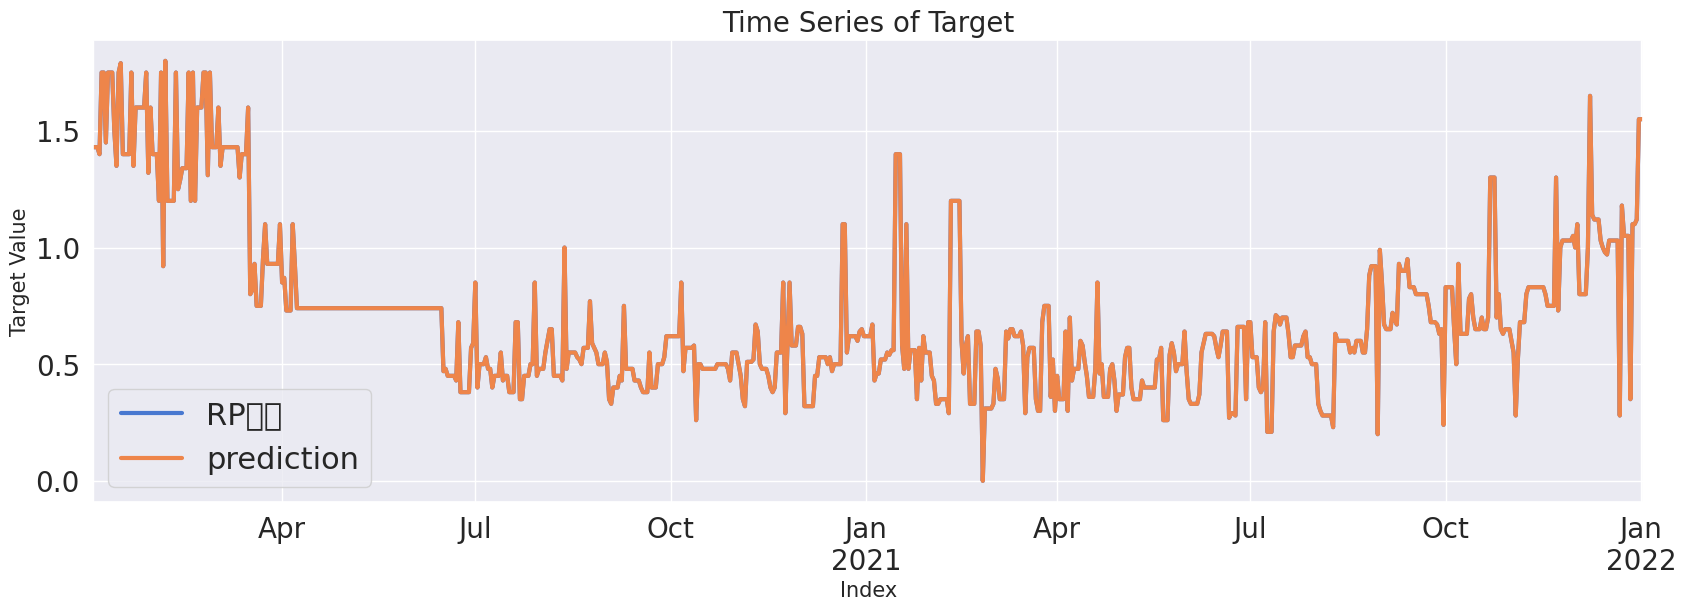

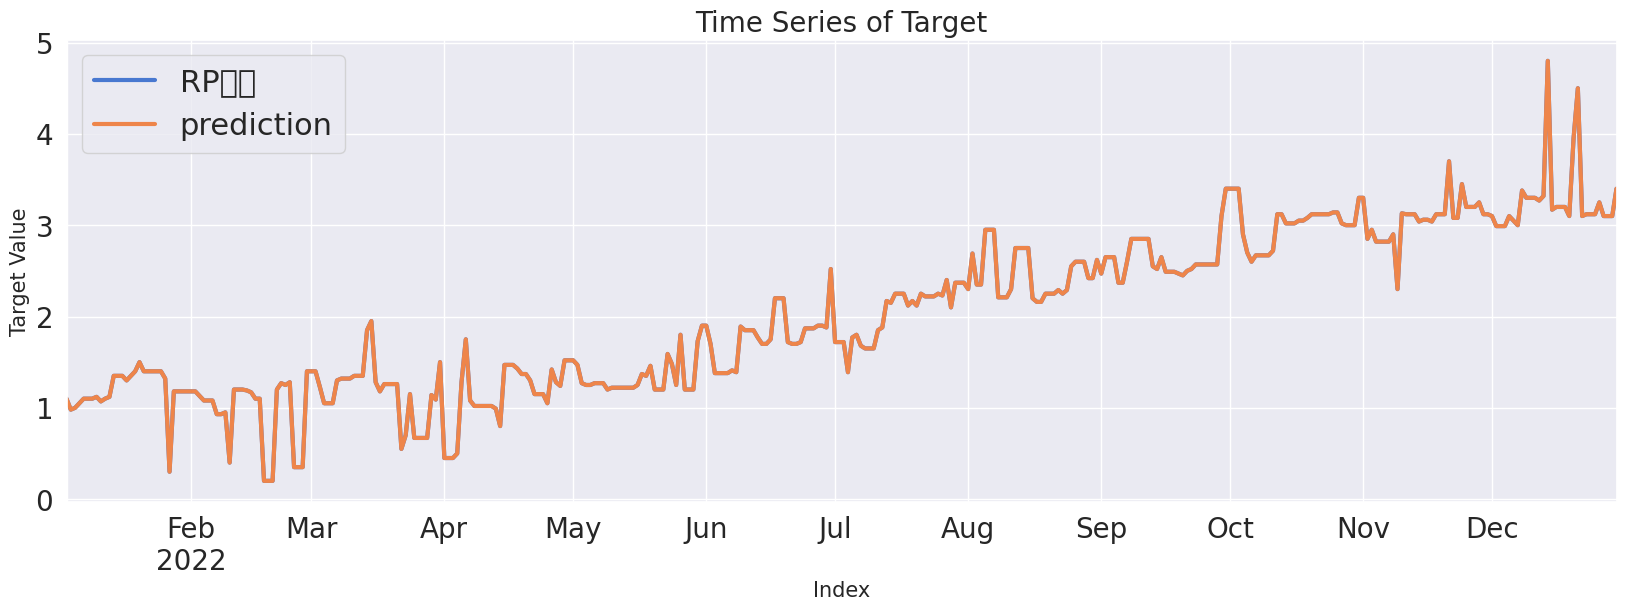

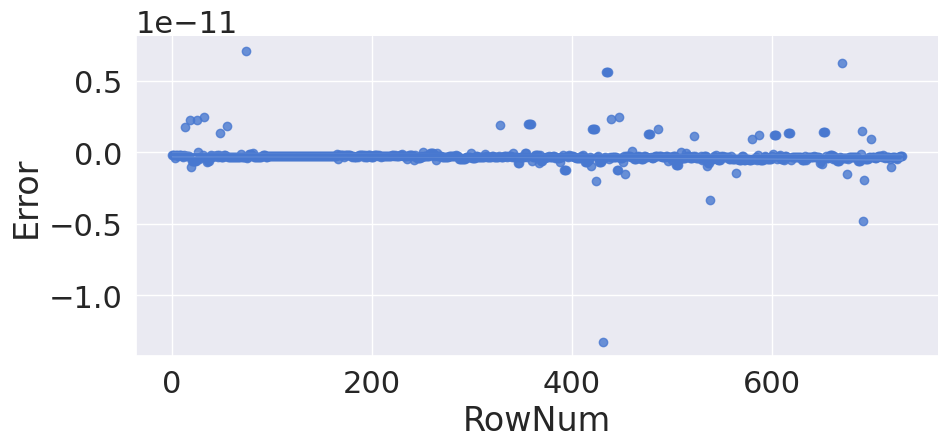

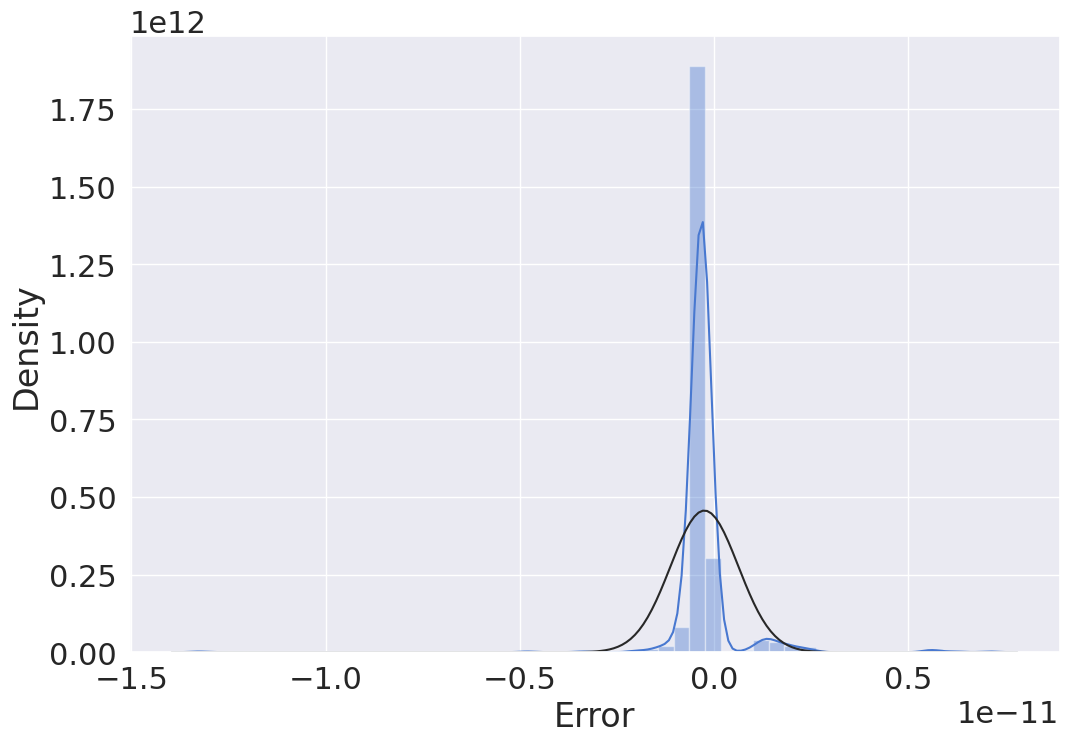

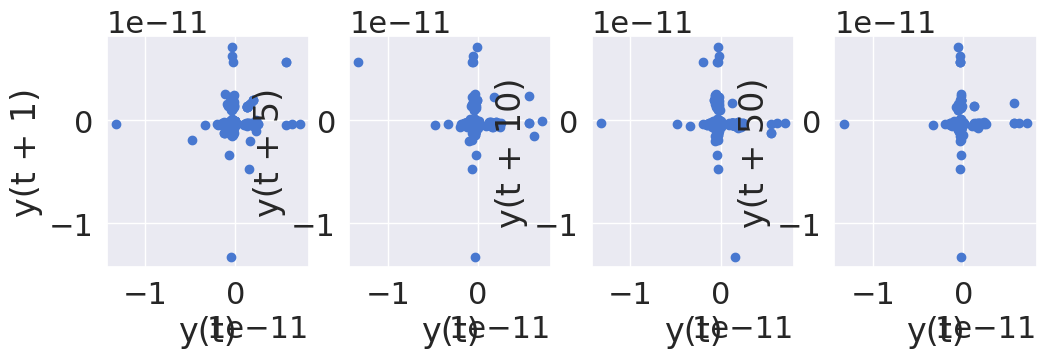

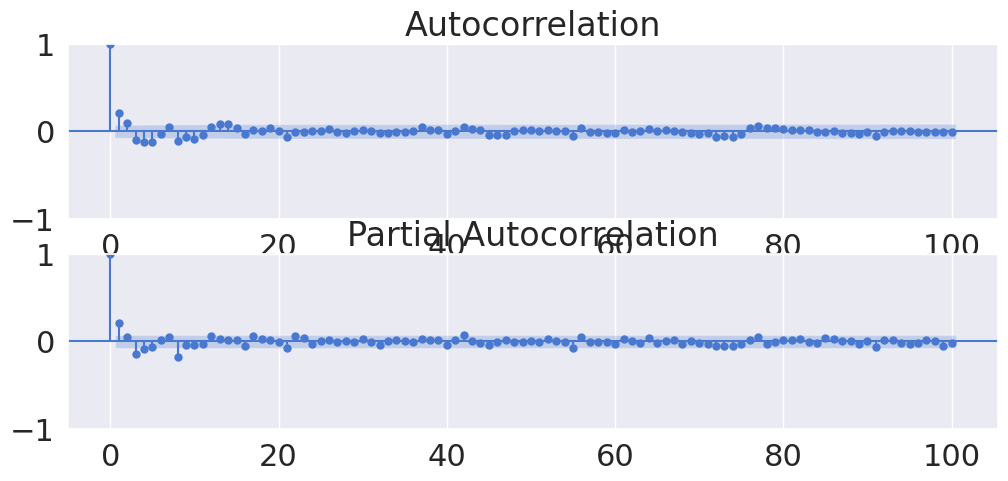

In [41]:
if __name__ == "__main__" : 
    main()
    # 2020-01-10(2) Error
    # 

In [ ]:
CaseForTradingRepo["기준일자"] = pd.datetime(CaseForTradingRepo["기준일자"])

,기준일자,매입증권수,매입증권매입금액,매입증권평가금액,매수단기금융업종구분코드,매수단기금융업종명,유가증권국제인증고유번호,유가증권국제인증고유번호코드명,상환기간분류코드,상환기간분류코드명,...,RP이율,RP증거금비율,RP개시일자,RP잔존만기구분코드,RP잔존만기,RP일련번호,유가증권종목종류코드,유가증권종목명,매도단기금융업종구분코드,매도단기금융업종명
0,20200110,1000000,1020000000,1283883180,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200110,14.0,10년이하,202001100001,1110,국채,101,증권사
1,20200103,9610805222,10000000000,10110250000,202,은행(신탁),KR60000148C7,신한은행 22-12-이-3-B,1,1영업일,...,1.43,105,20200103,12.0,3년이하,202001030001,1150,은행채,101,증권사
2,20200106,19059592543,20000000000,20031100000,201,증권사(신탁),KR310508G996,중소기업은행(신) 1909이1.5A-24,1,1영업일,...,1.40,105,20200106,12.0,3년이하,202001060001,1150,은행채,701,여신 금융업
3,20200107,1000000,1020000000,1295321460,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200107,14.0,10년이하,202001070001,1110,국채,101,증권사
4,20200108,1000000,1020000000,1289487060,201,증권사(신탁),KR1035037T34,국고채권 05250-2703(07-3),1,1영업일,...,1.75,108,20200108,14.0,10년이하,202001080001,1110,국채,101,증권사
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,20221226,3100000000,3750000000,3448946250,204,집합투자,KR63161419A5,우리금융조건부(상)4(신종)(조건상각/콜/후),2,2영업일이상 7일미만,...,3.25,100,20221226,15.0,10년초과,202212260001,1160,금융채,204,집합투자
676,20221227,170000000000,247900000000,181916952800,301,국내은행,KR103502G933,국고채권 02000-4903(19-2),1,1영업일,...,3.10,100,20221227,15.0,10년초과,202212270001,1110,국채,401,보험
677,20221228,500000000000,534100000000,515026220800,202,은행(신탁),KR103501GB67,국고채권 01125-2406(21-4),1,1영업일,...,3.10,100,20221228,12.0,3년이하,202212280001,1110,국채,301,국내은행
678,20221229,170000000000,248700000000,181923055200,301,국내은행,KR103502G933,국고채권 02000-4903(19-2),1,1영업일,...,3.10,100,20221229,15.0,10년초과,202212290001,1110,국채,401,보험


```
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Applying Base Model
fit_reg1_feR = sm.OLS(Y_train_feR, X_train_feR).fit()
display(fit_reg1_feR.summary())
pred_tr_reg1_feR = fit_reg1_feR.predict(X_train_feR).values
pred_te_reg1_feR = fit_reg1_feR.predict(X_test_feR).values

# Evaluation
Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR,
                                                                   Y_test_feR, pred_te_reg1_feR, graph_on=True)
display(Score_reg1_feR)

# Error Analysis
error_analysis(Resid_tr_reg1_feR, ['Error'], X_train_feR, graph_on=True)
```